<a href="https://colab.research.google.com/github/komazawa-deep-learning/komazawa-deep-learning.github.io/blob/master/2021notebooks/2021_0925face_dataset_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -*- coding: utf8 -*-

# 顔，非顔判別データセットを用いた紡錘状回のモデル化 --- 転移学習を用いた顔検出モデル ---

- source: file:///Users/asakawa/study/2020pytorch_tutorials.git/beginner_source/transfer_learning_tutorial.py
- data: 2021_1001
- author: 浅川伸一
- filename: 2021_0925face_dataset_transfer_leaning.ipynb
- original author: [Sasank Chilamkurthy](https://chsasank.github.io)
- License: BSD

実際には， 十分なサイズのデータセットを持つことは比較的まれであるため， 最初から (ランダムな初期化を行って) 畳み込みニューラルネットワーク全体を学習する人はほとんどいない。その代わり， 非常に大規模なデータセット (例えば 120 万枚の画像と 1000 カテゴリの ImageNet) で ConvNet を事前学習し， その ConvNet を初期化または目的の課題のための固定の特徴抽出器として使用するのが一般的である。
<!-- In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively     rare to have a dataset of sufficient size. 
    Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.   -->

この 2 つの主要な転送学習シナリオは次のようになる。

- **畳み込みニューラルネットワークの初期化**  ランダムな初期化の代わりに imagenet 1000 データセットで学習されたような， 事前学習されたネットワークでネットワークを初期化する。
- **微調整 fine tuning 学習** その後の学習は通常通り
- **転移学習 transfer learning** 最後の完全連結層を除いて，すべてのネットワークの重みを固定する。
この最終完全連結層は，ランダムな重みを持つ新しい層に置き換えられ，この層だけが学習される。


- 資料:
転移学習については [cs231n notes](https://cs231n.github.io/transfer-learning/)で詳しく紹介されている。


In [1]:
# データの取得
import platform
isColab = True if platform.system() == 'Linux' else False
if isColab:
    !wget https://komazawa-deep-learning.github.io/2021komazawa_faces.tgz -O 2021komazawa_faces.tgz
    !tar xzf 2021komazawa_faces.tgz

    !pip install japanize_matplotlib

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import japanize_matplotlib
import time
import os
import copy

%matplotlib inline
plt.ion()   # interactive mode

# GPU が利用可能かどうかを調べる
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# GPU が利用可能であれば n_worker=2 にし，そうでなければ 4 に設定
n_worker = 4 if device == 'cpu' else 2

In [3]:
# 訓練データに対しては，データ拡張と正規化を行い
# 検証データに対しては，正規化を行う
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),  # ランダムに左右反転
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size=64,
                                              shuffle=True, 
                                              num_workers=n_worker, 
                                              drop_last=True)
              for x in ['train', 'val']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(f'分類するクラス名 :{class_names}')
print(f'データセットのサイズ:{dataset_sizes}')

分類するクラス名 :['face', 'non-face']
データセットのサイズ:{'train': 6977, 'val': 2829}


# 1. データの可視化

  顔   顔   顔 非顔 非顔 非顔 非顔 非顔 
非顔 非顔   顔   顔 非顔 非顔   顔   顔 
非顔   顔 非顔 非顔 非顔 非顔 非顔   顔 
  顔   顔   顔 非顔   顔 非顔 非顔 非顔 
非顔 非顔 非顔 非顔   顔 非顔 非顔   顔 
非顔 非顔   顔   顔   顔 非顔 非顔 非顔 
非顔 非顔   顔   顔 非顔 非顔 非顔   顔 
  顔   顔 非顔   顔 非顔 非顔 非顔 非顔 


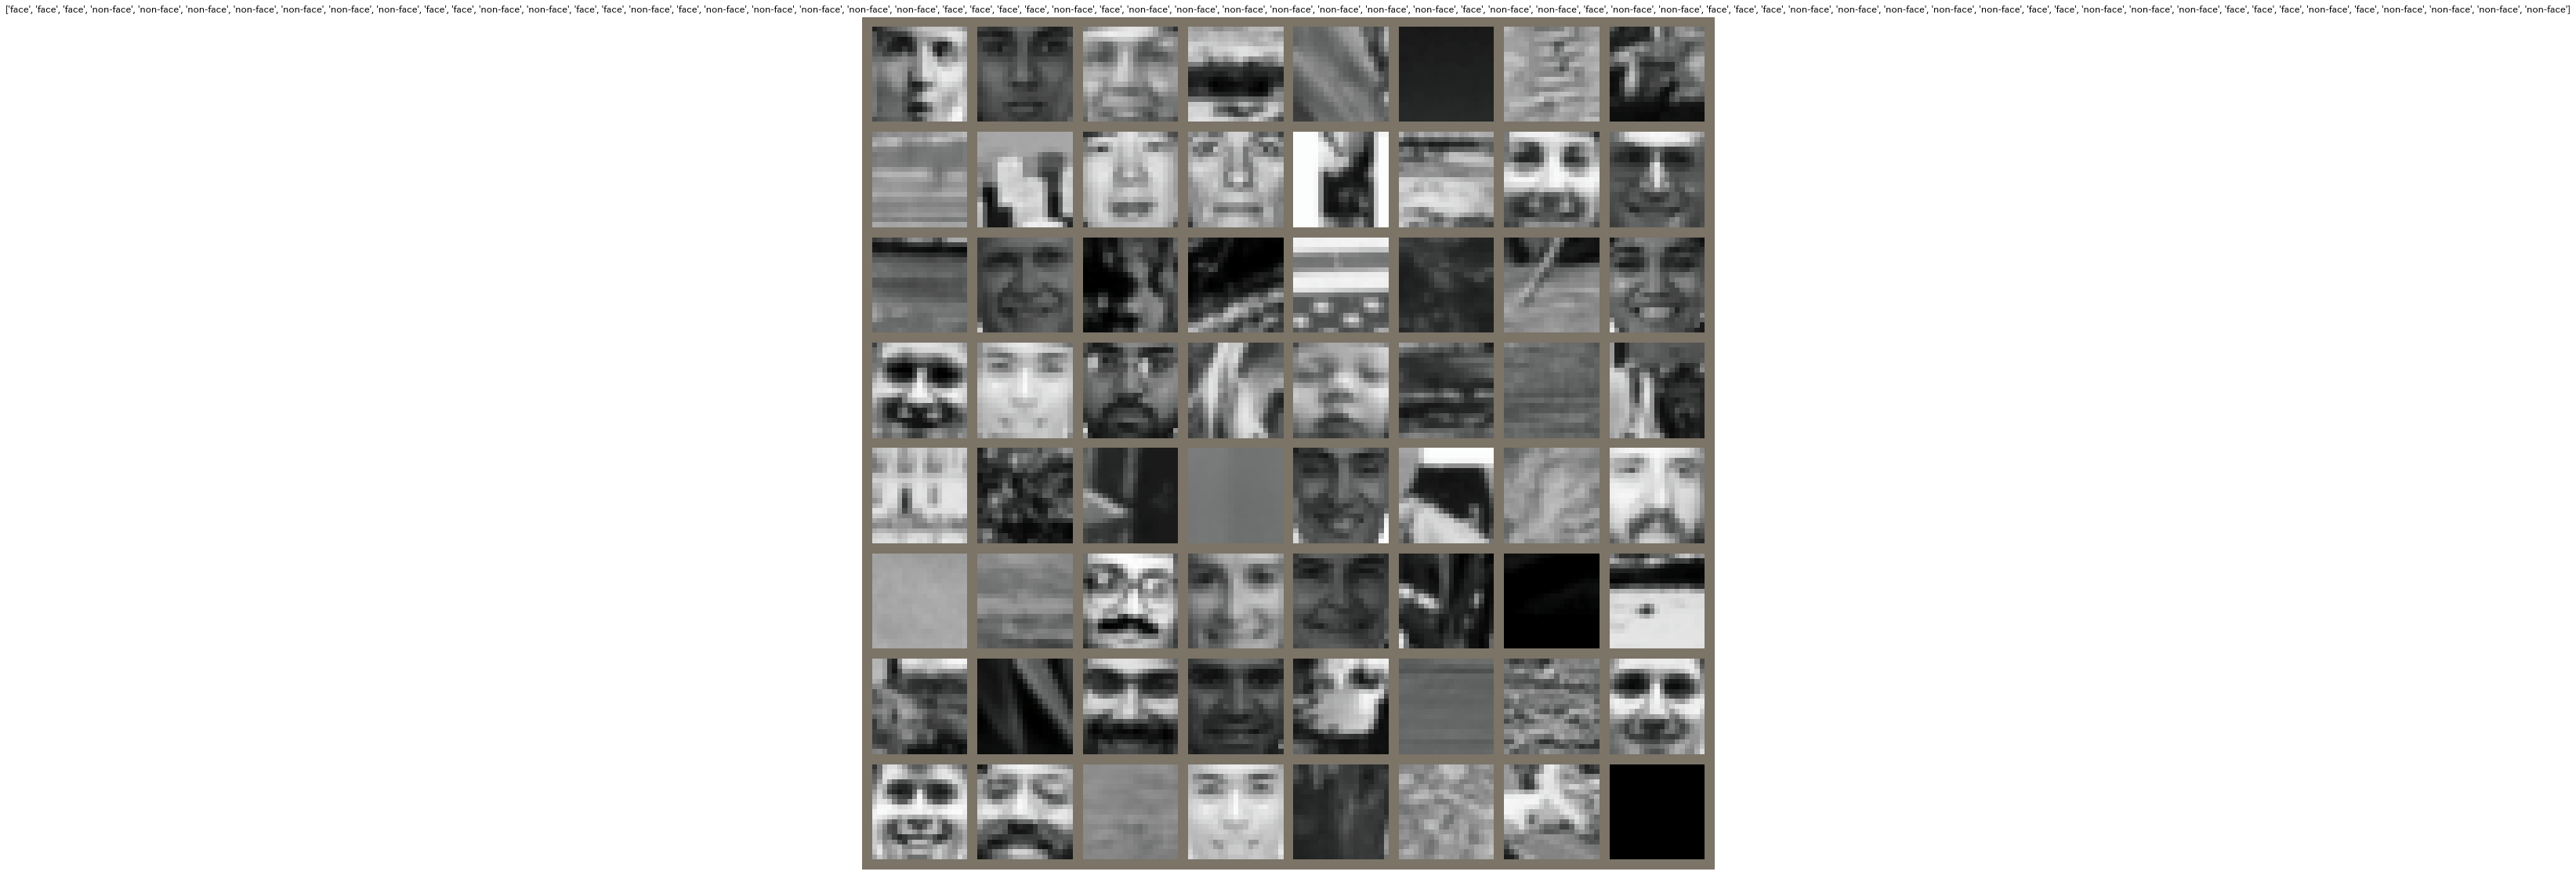

In [4]:
def imshow(inp, title=None, figsize=(10,10)):
    """テンソルを画像として表示"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    #plt.pause(0.001)  # pause a bit so that plots are updated


# ミニバッチサイズ分のデータを取得する
inputs, classes = next(iter(dataloaders['train']))

# バッチ分の出力を得る
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes], figsize=(20,20))
for i, v in enumerate(classes):
    v_ja = '非顔' if v == 1 else '  顔'
    print(v_ja, end=" ")
    if (i+1) % 8 == 0:
        print()

# 2. モデルの訓練

モデルを訓練するための一般的な関数を定義

- 学習率のスケジューリング
- ベストモデルの保存

以下では パラメータ ``scheduler`` に ``torch.optim.lr_scheduler`` の LR スケジューラオブジェクトを指定しています。
<!-- Now, let's write a general function to train a model. 
Here, we will illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from ``torch.optim.lr_scheduler``. -->

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'エポック {epoch}/{num_epochs - 1}')

        # 各エポックごとに，訓練データを用いた学習と検証データを用いた検証を繰り返す
        for phase in ['train', 'val']:
            if phase == '訓練':
                model.train()  # 訓練モード, PyTorch では学習時に設定
            else:
                model.eval()   # 評価モード，PyTorch では評価時に設定，学習は行われない

            running_loss = 0.0
            running_corrects = 0

            # データセット中の全データを用いて繰り返し
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 勾配の初期化
                optimizer.zero_grad()

                # 前向き処理
                # 訓練時は学習履歴を保存しておく
                cnt = 0
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 逆向き処理，学習時
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 損失値の計算
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase:<6s} 損失: {epoch_loss:.3f} 精度: {epoch_acc:.3f}')

            # 性能が良ければ保存する
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since
    print(f'訓練終了 {time_elapsed // 60:.0f}分 {time_elapsed % 60:.0f}秒')
    print(f'最良精度: {best_acc:4f}')

    # 最良精度達成時のモデルを返す
    model.load_state_dict(best_model_wts)
    return model

# 3. モデル予測の視覚化

<!-- # Visualizing the model predictions --->
<!--
# Generic function to display predictions for a few images
-->

In [6]:
def visualize_model(model, n_images=4, figsize=(3,3)):
    """結果の確認
    引数:
    model: torch.nn.modules.module.Module
        評価すべきモデル (ResNet などを仮定)
    n_images: int
        表示する画像枚数
    figsize: tupule (int, int)
        画像の表示サイズ 縦横のインチ数
    出力: None
    """
        
    inputs, labels = next(iter(dataloaders['train']))
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    p, preds = torch.max(outputs, 1)

    for i in range(n_images):
        title = f'予想: {class_names[preds[i]]}'
        imshow(inputs.cpu().data[i], title=title, figsize=figsize)


# 3. 微調整 finetuning 学習

微調整 fine tuning とは，事前学習済モデルに対して，全パラメータを学習し直すことを指します

In [7]:
model_finetune = models.resnet18(pretrained=True)
n_feature = model_finetune.fc.in_features
# 最終層のニューロン数を 2 に付け替え
# これは，顔 非顔の 2 分類にするために 2 としている。
# 事前学習済のモデルは Imagenet の 1000 分類なので，最終層のニューロン数は 1000 になっている。
# この 1000 個の出力層ニューロンは，一般画像認識のための出力層ニューロン数であるため，
# 2 (顔，非顔) に置き換える
model_finetune.fc = nn.Linear(n_feature, len(class_names))
model_finetune = model_finetune.to(device)

criterion = nn.CrossEntropyLoss()  # 交差エントロピー損失を評価関数とする

# 最適化手法として，確率的勾配降下法 (Bottou, 2003) を用いる
#optimizer_finetune = optim.SGD(model_finetune.parameters(), lr=0.001, momentum=0.9)
optimizer_finetune = optim.Adam(model_finetune.fc.parameters(), lr=0.001)

# 学習係数 LR を 7 エポック毎に減衰させる
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_finetune, step_size=1, gamma=0.1)

## 3.1 微調整学習による訓練と評価

In [8]:
model_finetune = train_model(model_finetune, 
                             criterion, 
                             optimizer_finetune, 
                             exp_lr_scheduler,
                             num_epochs=3)

エポック 0/2
train  損失: 0.266 精度: 0.903
val    損失: 0.720 精度: 0.830
エポック 1/2
train  損失: 0.178 精度: 0.937
val    損失: 0.720 精度: 0.830
エポック 2/2
train  損失: 0.170 精度: 0.940
val    損失: 0.724 精度: 0.829
訓練終了 22分 46秒
最良精度: 0.829622


## 3.2 微調整学習による学習結果の視覚化

In [ ]:
visualize_model(model_finetune, figsize=(2,2), n_images=5)

# 4. 転移学習 transfer learning による顔識別器の訓練


ここでは， 最終層を除くすべてのネットワークを凍結させる必要があります。
また  ``requires_grad == False``  を設定してパラメータを固定し，  ``backward()``  で勾配が計算されないようにする必要があります。

これについての詳細は，以下の文書をご覧ください:
<https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>

<!-- Here, we need to freeze all the network except the final layer. 
We need to set ``requires_grad == False`` to freeze the parameters so that the gradients are not computed in ``backward()``.

You can read more about this in the documentation 
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`. -->

In [ ]:
model_transfer = torchvision.models.resnet18(pretrained=True)
for param in model_transfer.parameters():
    param.requires_grad = False

# 新しく追加したパラメータはあらかじめ，requires_grad=True すなわち学習可能な状態になっている
n_feature = model_transfer.fc.in_features
model_transfer.fc = nn.Linear(n_feature, len(class_names))
model_transfer = model_transfer.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr=0.001) # , momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_transfer, step_size=7, gamma=0.1)

# 4.1 訓練と評価
<!-- # Train and evaluate -->

CPU では 先ほどのシナリオと比べて約半分の時間で済みます。
これは， ネットワークのほとんどの部分で勾配を計算する必要がないことから予想されます。
しかし，前向き計算は実行する必要があります。
<!-- On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the network. 
However, forward does need to be computed.
 -->

In [ ]:
model_transfer = train_model(model_transfer,
                             criterion, 
                             optimizer_transfer,
                             exp_lr_scheduler, 
                             num_epochs=5)

In [ ]:
# 結果の表示
visualize_model(model_finetune)